# Fashion AI — Image+Color (MTL) with Template Captions
Runs on Kaggle or locally.

In [5]:
# ===== Env & paths =====
import os
from pathlib import Path
IS_KAGGLE = os.path.exists("/kaggle")

def _discover_kaggle_raw():
    base = Path("/kaggle/input")
    if not base.exists():
        return None
    for p in base.rglob("*"):
        try:
            if p.is_dir() and (p/"styles.csv").exists() and (p/"images").exists():
                return p
        except Exception:
            pass
    return None

if IS_KAGGLE:
    RAW = _discover_kaggle_raw()
    if RAW is None:
        raise FileNotFoundError("Attach a Kaggle dataset containing styles.csv and images/")
    PROCESSED = Path("/kaggle/working/processed")
else:
    RAW = Path("../data/raw/fashion-dataset")
    PROCESSED = Path("../data/processed")

PROCESSED.mkdir(parents=True, exist_ok=True)
styles_csv = RAW/"styles.csv"
images_dir = RAW/"images"
print("RAW:", RAW); print("PROCESSED:", PROCESSED); print("Exists:", styles_csv.exists(), images_dir.exists())

RAW: /kaggle/input/fashion-product-images-dataset/fashion-dataset
PROCESSED: /kaggle/working/processed
Exists: True True


In [6]:
# ===== Imports & device =====
import json, re, random, time
from collections import Counter

import numpy as np
import pandas as pd
from PIL import Image

import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
from torchvision.models import resnet18, ResNet18_Weights

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder

print("torch:", torch.__version__, "| torchvision:", torchvision.__version__)
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True
print("Device:", device)
if torch.cuda.is_available(): print("GPU:", torch.cuda.get_device_name(0))

torch: 2.6.0+cu124 | torchvision: 0.21.0+cu124
Device: cuda
GPU: Tesla T4


In [7]:
# ===== Load, filter, clean, color, caption_target =====
df = pd.read_csv(styles_csv, on_bad_lines="skip")
df = df.dropna(subset=["articleType"])
df["image_path"] = df["id"].apply(lambda x: images_dir / f"{x}.jpg")
df = df[df["image_path"].apply(lambda p: p.exists())].reset_index(drop=True)

# removes rare classes
MIN_SAMPLES = 9
valid = df["articleType"].value_counts()
valid = valid[valid >= MIN_SAMPLES].index
df = df[df["articleType"].isin(valid)].reset_index(drop=True)

def clean_text(s):
    s = str(s).lower()
    s = re.sub(r"[^a-z0-9\s]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s
df["clean_name"] = df["productDisplayName"].apply(clean_text)

def _norm_word(s):
    s = str(s).lower()
    s = re.sub(r"[^a-z0-9\s]", " ", s)
    return re.sub(r"\s+", " ", s).strip()

COLOR_COL = "baseColour" if "baseColour" in df.columns else ("baseColor" if "baseColor" in df.columns else None)
if COLOR_COL is None:
    df["color_norm"] = "unknown"
else:
    df["color_norm"] = df[COLOR_COL].fillna("").map(_norm_word).replace("", "unknown")

# brandless caption target: color + class
df["caption_target"] = (df["color_norm"] + " " + df["articleType"].str.lower()).str.strip()

print("Rows:", len(df), "| Classes:", df["articleType"].nunique())
df[["articleType","color_norm","caption_target"]].head()

Rows: 44283 | Classes: 109


,articleType,color_norm,caption_target
0,Shirts,navy blue,navy blue shirts
1,Jeans,blue,blue jeans
2,Watches,silver,silver watches
3,Track Pants,black,black track pants
4,Tshirts,grey,grey tshirts


In [8]:
# ===== Label encodings (class + color) =====
le_cls = LabelEncoder()
df["label_id"] = le_cls.fit_transform(df["articleType"])
label_mapping = {cls: int(i) for cls, i in zip(le_cls.classes_, le_cls.transform(le_cls.classes_))}
with open(PROCESSED/"label_mapping.json", "w") as f:
    json.dump(label_mapping, f, indent=2)

le_col = LabelEncoder()
df["color_id"] = le_col.fit_transform(df["color_norm"])
color_mapping = {cls: int(i) for i, cls in enumerate(le_col.classes_)}
with open(PROCESSED/"color_mapping.json", "w") as f:
    json.dump(color_mapping, f, indent=2)

print("num_classes:", len(label_mapping), "| num_colors:", len(color_mapping))

num_classes: 109 | num_colors: 47


In [9]:
# ===== Stratified split 70/15/15 (on label) =====
RANDOM_STATE = 42
split1 = StratifiedShuffleSplit(n_splits=1, test_size=0.30, random_state=RANDOM_STATE)
train_idx, temp_idx = next(split1.split(df, df["label_id"]))

df_train = df.iloc[train_idx].reset_index(drop=True)
df_temp  = df.iloc[temp_idx].reset_index(drop=True)

split2 = StratifiedShuffleSplit(n_splits=1, test_size=0.50, random_state=RANDOM_STATE)
val_idx, test_idx = next(split2.split(df_temp, df_temp["label_id"]))

df_val  = df_temp.iloc[val_idx].reset_index(drop=True)
df_test = df_temp.iloc[test_idx].reset_index(drop=True)

with open(PROCESSED/"split_indices.json","w") as f:
    json.dump({
        "train_index": train_idx.tolist(),
        "val_index": temp_idx[val_idx].tolist(),
        "test_index": temp_idx[test_idx].tolist()
    }, f, indent=2)

print("Train/Val/Test:", len(df_train), len(df_val), len(df_test))

Train/Val/Test: 30998 6642 6643


In [10]:
# ===== Transforms (color-safe) =====
train_transformations = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=5),
    transforms.ColorJitter(brightness=0.05, contrast=0.05, saturation=0.02, hue=0.02),
    transforms.RandomAffine(degrees=0, translate=(0.05,0.05)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])
val_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

In [11]:
# ===== Dataset (image, caption_target, label_id, color_id) =====
class FashionDatasetMTL(Dataset):
    def __init__(self, dataframe, image_transform=None, text_key="caption_target"):
        self.df = dataframe.reset_index(drop=True)
        self.image_transform = image_transform
        self.text_key = text_key
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        path = row["image_path"]
        try:
            img = Image.open(path).convert("RGB")
        except Exception:
            img = Image.new("RGB", (224,224), (0,0,0))
        if self.image_transform: img = self.image_transform(img)
        return img, row[self.text_key], int(row["label_id"]), int(row["color_id"])

In [12]:
# ===== DataLoaders =====
BATCH_SIZE = 32
NUM_WORKERS_TRAIN = 2 if IS_KAGGLE else 0
PIN = bool(IS_KAGGLE and torch.cuda.is_available())

train_dataset = FashionDatasetMTL(df_train, image_transform=train_transformations)
val_dataset   = FashionDatasetMTL(df_val,   image_transform=val_transforms)
test_dataset  = FashionDatasetMTL(df_test,  image_transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS_TRAIN, pin_memory=PIN,
                          persistent_workers=bool(NUM_WORKERS_TRAIN), prefetch_factor=2 if NUM_WORKERS_TRAIN else 2)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

xb, tb, yb, cb = next(iter(train_loader))
print("Batch:", tuple(xb.shape), "| text[0]:", tb[0][:60], "| y:", int(yb[0]), "| c:", int(cb[0]))

Batch: (32, 3, 224, 224) | text[0]: blue perfume and body mist | y: 69 | c: 2


In [13]:
# ===== Class weights (for articleType) =====
class_counts = Counter(df_train["label_id"])
num_classes = len(class_counts)
total = sum(class_counts.values())
class_weights = torch.tensor([total/(num_classes*class_counts[i]) for i in range(num_classes)], dtype=torch.float)
torch.save(class_weights, PROCESSED/"class_weights.pt")
print("Saved class_weights to:", PROCESSED/"class_weights.pt")

Saved class_weights to: /kaggle/working/processed/class_weights.pt


In [14]:
# ===== Simple tokenizer for caption_target =====
class SimpleTokenizer:
    PAD="<pad>"; UNK="<unk>"
    def __init__(self, min_freq=1, lowercase=True):
        self.min_freq=min_freq; self.lowercase=lowercase
        self.stoi={self.PAD:0,self.UNK:1}; self.itos=[self.PAD,self.UNK]; self.freqs={}
    def _norm(self, s):
        s=str(s).lower() if self.lowercase else str(s)
        s=re.sub(r"[^a-z0-9\s]"," ",s)
        return re.sub(r"\s+"," ",s).strip()
    def tokenize(self, s): return self._norm(s).split()
    def fit(self, texts):
        for t in texts:
            for tok in self.tokenize(t):
                self.freqs[tok]=self.freqs.get(tok,0)+1
        for tok,f in sorted(self.freqs.items()):
            if f>=self.min_freq and tok not in self.stoi:
                self.stoi[tok]=len(self.itos); self.itos.append(tok)
    def encode(self, s, max_len=32):
        toks=self.tokenize(s)
        ids=[self.stoi.get(tok,1) for tok in toks[:max_len]]
        if len(ids)<max_len: ids += [0]*(max_len-len(ids))
        mask=[1 if i!=0 else 0 for i in ids]
        return ids, mask

tokenizer = SimpleTokenizer(min_freq=1, lowercase=True)
tokenizer.fit(df_train["caption_target"].tolist())
with open(PROCESSED/"vocab_simple.json","w") as f:
    json.dump({"itos": tokenizer.itos}, f)
print("Vocab size:", len(tokenizer.itos))

def encode_text_batch(texts, tokenizer, max_len=32, device="cpu"):
    ids_b, mask_b = [], []
    for t in texts:
        ids, mask = tokenizer.encode(t, max_len=max_len)
        ids_b.append(ids); mask_b.append(mask)
    ids  = torch.tensor(ids_b, dtype=torch.long, device=device)
    mask = torch.tensor(mask_b, dtype=torch.float32, device=device)
    return ids, mask

Vocab size: 185


In [15]:
# ===== ResNet18 MTL model (class + color) =====
def get_resnet18(pretrained=True):
    return resnet18(weights=ResNet18_Weights.IMAGENET1K_V1 if pretrained else None)

num_classes = len(label_mapping)
num_colors  = len(color_mapping)
id2label = {v:k for k,v in label_mapping.items()}
id2color = {i:c for c,i in color_mapping.items()}

class ImageEncoderResNet(nn.Module):
    def __init__(self, feature_dim=256, pretrained=True, dropout=0.1):
        super().__init__()
        self.backbone = get_resnet18(pretrained=pretrained)
        in_feats = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()
        self.proj = nn.Sequential(
            nn.Linear(in_feats, feature_dim),
            nn.BatchNorm1d(feature_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
        )
    def forward(self, x):
        return self.proj(self.backbone(x))

class ImageMTL(nn.Module):
    def __init__(self, feature_dim=256, pretrained=True):
        super().__init__()
        self.image_encoder = ImageEncoderResNet(feature_dim=feature_dim, pretrained=pretrained)
        self.cls_head   = nn.Linear(feature_dim, num_classes)
        self.color_head = nn.Linear(feature_dim, num_colors)
    def forward(self, images):
        z = self.image_encoder(images)
        return self.cls_head(z), self.color_head(z), z

img_mtl = ImageMTL(pretrained=True).to(device)
print("Params:", sum(p.numel() for p in img_mtl.parameters() if p.requires_grad))

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 172MB/s] 


Params: 11348444


In [16]:
# ===== Train (class CE + 0.5 * color CE) =====
from torch.cuda.amp import autocast, GradScaler

ce_cls   = nn.CrossEntropyLoss(weight=class_weights.to(device) if class_weights is not None else None)
ce_color = nn.CrossEntropyLoss()
ALPHA_COLOR = 0.5

optimizer = torch.optim.AdamW(img_mtl.parameters(), lr=3e-4, weight_decay=1e-4)
scaler = GradScaler(enabled=torch.cuda.is_available())

def train_epoch(model, loader):
    model.train()
    tot, correct, n = 0.0, 0, 0
    for step, (xb, tb, yb, cb) in enumerate(loader, 1):
        xb, yb, cb = xb.to(device), yb.to(device), cb.to(device)
        optimizer.zero_grad(set_to_none=True)
        with autocast(enabled=torch.cuda.is_available()):
            logits_cls, logits_color, _ = model(xb)
            loss = ce_cls(logits_cls, yb) + ALPHA_COLOR * ce_color(logits_color, cb)
        scaler.scale(loss).backward()
        scaler.step(optimizer); scaler.update()
        b = xb.size(0); tot += loss.item()*b; correct += (logits_cls.argmax(1)==yb).sum().item(); n += b
        if step % 200 == 0:
            print(f"  step {step:4d}: loss={tot/n:.4f} acc={(correct/n)*100:.2f}%")
    return tot/n, correct/n

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    tot, correct, n = 0.0, 0, 0
    color_correct = 0
    for xb, tb, yb, cb in loader:
        xb, yb, cb = xb.to(device), yb.to(device), cb.to(device)
        logits_cls, logits_color, _ = model(xb)
        loss = ce_cls(logits_cls, yb) + ALPHA_COLOR * ce_color(logits_color, cb)
        b = xb.size(0); tot += loss.item()*b; correct += (logits_cls.argmax(1)==yb).sum().item(); color_correct += (logits_color.argmax(1)==cb).sum().item(); n += b
    return tot/n, correct/n, color_correct/n

EPOCHS = 3
best = {"acc": 0.0}
CKPT_DIR = PROCESSED/"checkpoints"; CKPT_DIR.mkdir(parents=True, exist_ok=True)

for ep in range(1, EPOCHS+1):
    print(f"\n[MTL] Epoch {ep}/{EPOCHS}")
    tr_loss, tr_acc = train_epoch(img_mtl, train_loader)
    va_loss, va_acc, va_color = evaluate(img_mtl, val_loader)
    print(f"  train acc={tr_acc*100:.2f}% | val cls={va_acc*100:.2f}% | val color={va_color*100:.2f}%")
    if va_acc > best["acc"]:
        best.update(acc=va_acc, epoch=ep)
        torch.save({"model_state_dict": img_mtl.state_dict()}, CKPT_DIR/"image_mtl_best.pt")
        print("  ✅ saved image_mtl_best.pt")

print(f"\nBest val cls acc: {best['acc']*100:.2f}% at epoch {best['epoch']}")

/tmp/ipykernel_36/1711354240.py:9: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=torch.cuda.is_available())



[MTL] Epoch 1/3


/tmp/ipykernel_36/1711354240.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):


  step  200: loss=4.8337 acc=36.75%
  step  400: loss=4.2257 acc=44.77%
  step  600: loss=3.8672 acc=49.57%
  step  800: loss=3.5790 acc=53.16%
  train acc=55.32% | val cls=67.40% | val color=53.42%
  ✅ saved image_mtl_best.pt

[MTL] Epoch 2/3
  step  200: loss=2.1869 acc=68.95%
  step  400: loss=2.1879 acc=68.70%
  step  600: loss=2.1325 acc=69.43%
  step  800: loss=2.0642 acc=69.86%
  train acc=69.86% | val cls=69.59% | val color=57.66%
  ✅ saved image_mtl_best.pt

[MTL] Epoch 3/3
  step  200: loss=1.7382 acc=73.89%
  step  400: loss=1.6900 acc=74.16%
  step  600: loss=1.7151 acc=73.82%
  step  800: loss=1.7112 acc=73.83%
  train acc=74.08% | val cls=76.12% | val color=62.68%
  ✅ saved image_mtl_best.pt

Best val cls acc: 76.12% at epoch 3



GT: Tops | GT color: purple
Top-5: 1. Tops (0.48), 2. Tshirts (0.08), 3. Tunics (0.07), 4. Waistcoat (0.05), 5. Shapewear (0.04)
Caption (template): purple Tops


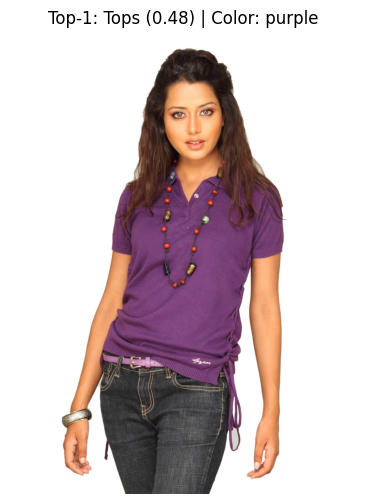


GT: Watches | GT color: silver
Top-5: 1. Watches (0.82), 2. Free Gifts (0.10), 3. Rucksacks (0.01), 4. Messenger Bag (0.00), 5. Backpacks (0.00)
Caption (template): black Watches


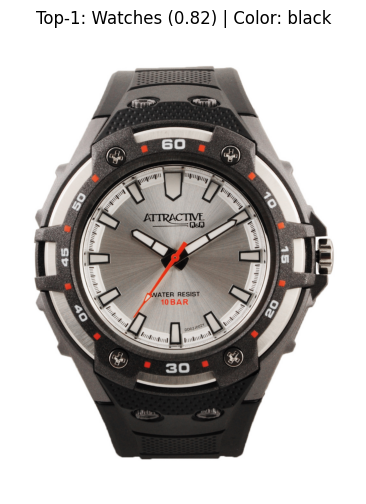


GT: Shorts | GT color: blue
Top-5: 1. Lounge Shorts (0.35), 2. Capris (0.19), 3. Skirts (0.08), 4. Boxers (0.08), 5. Shorts (0.06)
Caption (template): blue Lounge Shorts


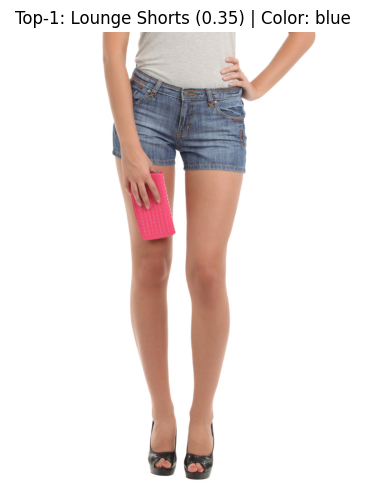


GT: Shirts | GT color: white
Top-5: 1. Shirts (0.97), 2. Jackets (0.01), 3. Tshirts (0.00), 4. Sweaters (0.00), 5. Sweatshirts (0.00)
Caption (template): blue Shirts


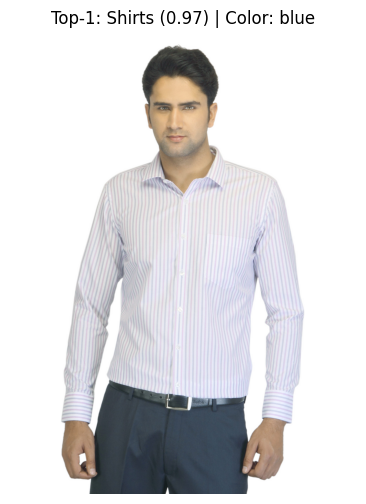

In [26]:
# ===== Inference: template caption + visualization (robust) =====
import json, random
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
import torch

# Ensure mappings exist
try:
    color_mapping
except NameError:
    with open(PROCESSED / "color_mapping.json") as f:
        color_mapping = json.load(f)

id2label = {v: k for k, v in label_mapping.items()}
id2color = {i: c for c, i in color_mapping.items()}

# load best weights if available
best_ckpt = PROCESSED / "checkpoints" / "image_mtl_best.pt"
if best_ckpt.exists():
    ckpt = torch.load(best_ckpt, map_location=device)
    img_mtl.load_state_dict(ckpt["model_state_dict"])
img_mtl.to(device).eval()

def load_image_as_tensor(path, transform, device):
    img = Image.open(path).convert("RGB")
    return transform(img).unsqueeze(0).to(device)

@torch.no_grad()
def predict_image_mtl(img_path, model, topk=5):
    x = load_image_as_tensor(img_path, val_transforms, device)
    logits_cls, logits_color, _ = model(x)
    probs = logits_cls.softmax(1)[0]
    vals, idxs = probs.topk(topk)
    pred_color = id2color[int(logits_color.argmax(1))]
    topk_list = [(id2label[int(i)], float(v)) for v, i in zip(vals, idxs)]
    return topk_list, pred_color

@torch.no_grad()
def template_caption_from_image(img_path, model):
    x = load_image_as_tensor(img_path, val_transforms, device)
    logits_cls, logits_color, _ = model(x)
    cls = id2label[int(logits_cls.argmax(1))]
    col = id2color[int(logits_color.argmax(1))]
    return f"{col} {cls}".strip()

# Visualization for 4 random VAL images
for idx in random.sample(range(len(df_val)), 4):
    img_path = Path(df_val.loc[idx, "image_path"])
    gt_cls   = df_val.loc[idx, "articleType"]
    gt_col   = df_val.loc[idx, "color_norm"]

    topk_list, pred_col = predict_image_mtl(img_path, img_mtl, topk=5)
    cap_tpl = template_caption_from_image(img_path, img_mtl)

    img = Image.open(img_path).convert("RGB")
    plt.figure(figsize=(6,6))
    plt.imshow(img); plt.axis("off")
    plt.title(f"Top-1: {topk_list[0][0]} ({topk_list[0][1]:.2f}) | Color: {pred_col}")

    print(f"\nGT: {gt_cls} | GT color: {gt_col}")
    print("Top-5:", ", ".join([f"{i+1}. {lbl} ({prob:.2f})" for i,(lbl,prob) in enumerate(topk_list)]))
    print("Caption (template):", cap_tpl)
    plt.show()

In [28]:
import os, shutil
ART_DIR = "/kaggle/working/exports"
os.makedirs(ART_DIR, exist_ok=True)

shutil.make_archive("/kaggle/working/artifacts", "zip", ART_DIR)
print("Created /kaggle/working/artifacts.zip")

Created /kaggle/working/artifacts.zip
